In [2]:
from profiler import *
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, time
from matplotlib import pyplot as plt

## Helper functions

In [16]:
flat_list= lambda x: [ g for f in x for g in f ]
double_list= lambda x: [[g] for g in x]
split_n= lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

def run_program(pargs, to_monitor, n=30, sample_period=0.05, reset_on_sample= True):
    """
        Run the program multiple times
    """
    try:
        all_data= []
        for i in tqdm(range(n)):
            program= Profiler(program_args=pargs, events_groups=to_monitor)
            data= program.run(sample_period=sample_period,reset_on_sample=reset_on_sample)
            all_data.append(data)
    except RuntimeError as e:
        print(e.args[0])
    return all_data

def smooth_df(runs, cols_names):
    """
        Resume multiple runs in one dataframe
        
        Remove outsamples using median split
        Average results and calculate standard deviation
    """
    count_shapes= defaultdict(lambda:0)
    for r in runs:
        count_shapes[np.shape(r)]+=1
    moda_shape= max(count_shapes,key=count_shapes.get)
    
    print("Moda shape counts {:.2f}%".format(count_shapes[moda_shape]/sum(count_shapes.values())*100))
    data_moda= [d for d in runs if np.shape(d) == moda_shape]

    big_l= []
    for r in data_moda:
        big_l.append(np.array(r).reshape(-1))
    big_l= np.asarray(big_l)
    
    med_avg= []
    std_avg= []
    for s in range(big_l.shape[1]):
        median= np.sort(big_l[:,s])[3:-3]
        med_avg.append(median.mean())
        std_avg.append(median.std())
    
    med_avg= np.asarray(med_avg)
    std_avg= np.asarray(std_avg)
    
    med_avg= pd.DataFrame(med_avg.reshape(moda_shape), columns=cols_names)
    std_avg= pd.DataFrame(std_avg.reshape(moda_shape), columns=cols_names)
    
    
    q= std_avg.values/med_avg.values
    print("AVG 68% samples error", np.nanmean(q))
    print("AVG 99% stds error", np.nanmean(3*q))
    print("MAX 68% stds error", np.nanmax(q))
    print("MAX 99% stds error", np.nanmax(3*q))
    
    return med_avg, std_avg

## Events specifications

In [4]:
all_events= get_event_description()
software_events= [e[0] for e in all_events if 'PERF_COUNT_SW' in e[0]]
hardware_events= [e[0] for e in all_events if 'PERF_COUNT_HW' in e[0]]
mem_events=[e[0] for e in all_events if 'MEM' in e[0] or 'CACHE' in e[0]]
rapl_events=['SYSTEMWIDE:'+e[0] for e in all_events if 'RAPL' in e[0]]
hw_groups= split_n(hardware_events, 5)

# Interrest
hw_events= double_list(['PERF_COUNT_HW_INSTRUCTIONS','PERF_COUNT_HW_BRANCH_INSTRUCTIONS','FP_COMP_OPS_EXE:X87',
                       'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES'])
mem_events= double_list(['MEM_UOPS_RETIRED:ALL_LOADS', 'MEM_UOPS_RETIRED:ALL_STORES'])
sw_events= [['PERF_COUNT_SW_CPU_CLOCK','PERF_COUNT_SW_PAGE_FAULTS','PERF_COUNT_SW_CONTEXT_SWITCHES',
                       'PERF_COUNT_SW_CPU_MIGRATIONS','PERF_COUNT_SW_PAGE_FAULTS_MAJ']]
rapl_events= double_list(rapl_events)
to_monitor= hw_events+mem_events+sw_events+rapl_events

for ev in flat_list(to_monitor):
    ev_split= ev.split(':')
    name= ev_split[1] if 'SYSTEMWIDE' in ev else ev_split[0]
    print( '%s: %s'%(name, get_event_description(name)[0][1]))
    if len(ev_split) > 1:
        for att in get_event_attrs(name):
            print('\t %s: %s'%(att[0],att[1]))

PERF_COUNT_HW_INSTRUCTIONS: PERF_COUNT_HW_INSTRUCTIONS
PERF_COUNT_HW_BRANCH_INSTRUCTIONS: PERF_COUNT_HW_BRANCH_INSTRUCTIONS
FP_COMP_OPS_EXE: Counts number of floating point events
	 X87: Number of X87 uops executed
	 SSE_FP_PACKED_DOUBLE: Number of SSE double precision FP packed uops executed
	 SSE_FP_SCALAR_SINGLE: Number of SSE single precision FP scalar uops executed
	 SSE_PACKED_SINGLE: Number of SSE single precision FP packed uops executed
	 SSE_SCALAR_DOUBLE: Number of SSE double precision FP scalar uops executed
	 e: edge level (may require counter-mask >= 1)
	 i: invert
	 c: counter-mask in range [0-255]
	 t: measure any thread
	 u: monitor at user level
	 k: monitor at kernel level
	 period: sampling period
	 freq: sampling frequency (Hz)
	 excl: exclusive access
	 mg: monitor guest execution
	 mh: monitor host execution
	 cpu: CPU to program
	 pinned: pin event to counters
PERF_COUNT_HW_BRANCH_MISSES: PERF_COUNT_HW_BRANCH_MISSES
PERF_COUNT_HW_CACHE_MISSES: PERF_COUNT_HW_CACHE

<h1>
    <a href="http://uops.info/table.html">UOPS- micro operations</a>
</h1>
<img src="pipeline.png" width=340> </img>
<p></p>

<img src="https://upload.wikimedia.org/wikipedia/commons/8/8c/Standard_deviation_diagram.svg" width=640px></img>

In [4]:
to_monitor

[['PERF_COUNT_HW_INSTRUCTIONS'],
 ['PERF_COUNT_HW_BRANCH_INSTRUCTIONS'],
 ['FP_COMP_OPS_EXE:X87'],
 ['PERF_COUNT_HW_BRANCH_MISSES'],
 ['PERF_COUNT_HW_CACHE_MISSES'],
 ['MEM_UOPS_RETIRED:ALL_LOADS'],
 ['MEM_UOPS_RETIRED:ALL_STORES'],
 ['PERF_COUNT_SW_CPU_CLOCK',
  'PERF_COUNT_SW_PAGE_FAULTS',
  'PERF_COUNT_SW_CONTEXT_SWITCHES',
  'PERF_COUNT_SW_CPU_MIGRATIONS',
  'PERF_COUNT_SW_PAGE_FAULTS_MAJ'],
 ['SYSTEMWIDE:RAPL_ENERGY_CORES'],
 ['SYSTEMWIDE:RAPL_ENERGY_PKG'],
 ['SYSTEMWIDE:RAPL_ENERGY_DRAM']]

```asm
section .text
    global _start
_start:
    push    rbp ; store rbp on the stack

    mov    rax, 60 ; syscall exit
    mov    rdi, 0 ; param 0
    syscall ; exit(0)

; 4 instructions
; 1 memory store
```

In [26]:
data= run_program(pargs=['benchs/store'],to_monitor=to_monitor,n=100,reset_on_sample=False)
avg_df, std_df= smooth_df(data, flat_list(to_monitor))
avg_df[['MEM_UOPS_RETIRED:ALL_STORES','PERF_COUNT_HW_INSTRUCTIONS']]

100%|██████████| 100/100 [00:06<00:00, 15.44it/s]

Moda shape counts 100.00%
AVG 68% samples error 10.996378425434632
AVG 99% stds error 32.98913527630389
MAX 68% stds error 35.448977705636295
MAX 99% stds error 106.34693311690889



/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


,MEM_UOPS_RETIRED:ALL_STORES,PERF_COUNT_HW_INSTRUCTIONS
0,1.0,5.0
1,1.0,5.0


```asm
section .data
    a: dq 123.45  ;declare quad word (double precision)

section .text
    global _start
_start:
    
    fld qword [a]   ;load a into st0
    fmul st0, st0   ;st0 = a * a = a^2

    mov    rax, 60
    mov    rdi, 0
    syscall

; 5 instructions
; 1 memory load
; 2 operations on fpu
```

In [27]:
data= run_program(pargs=['benchs/float'],to_monitor=to_monitor,n=100,reset_on_sample=False)
avg_df, std_df= smooth_df(data, flat_list(to_monitor))
avg_df[['FP_COMP_OPS_EXE:X87','PERF_COUNT_HW_INSTRUCTIONS']]

100%|██████████| 100/100 [00:06<00:00, 15.17it/s]

Moda shape counts 100.00%
AVG 68% samples error 12.461331297203278
AVG 99% stds error 37.38399389160983
MAX 68% stds error 45.032242851968775
MAX 99% stds error 135.09672855590634



/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


,FP_COMP_OPS_EXE:X87,PERF_COUNT_HW_INSTRUCTIONS
0,2.0,7.0
1,2.0,7.0


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]
/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
0it [00:00, ?it/s]

Moda shape counts 98.00%
AVG 68% samples error 5.819953201334212
AVG 99% stds error 17.459859604002638
MAX 68% stds error 62.63555053361408
MAX 99% stds error 187.90665160084222


15it [00:08,  1.84it/s]


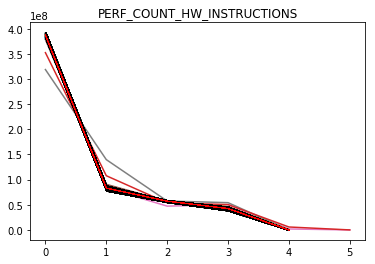

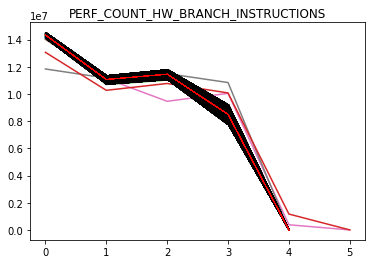

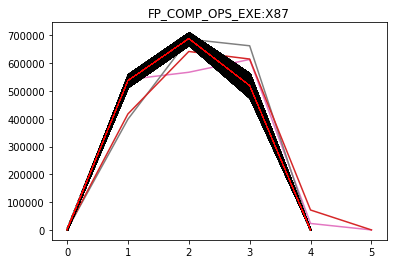

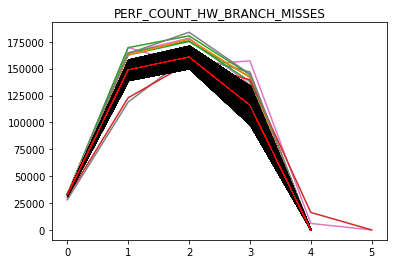

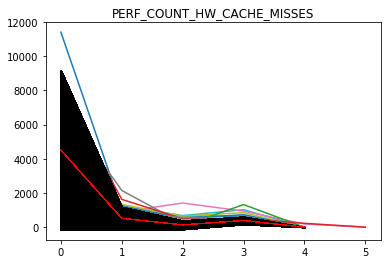

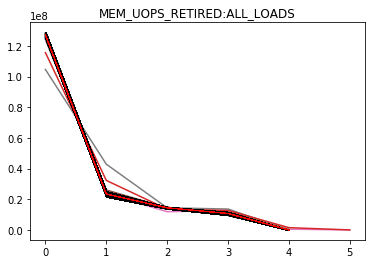

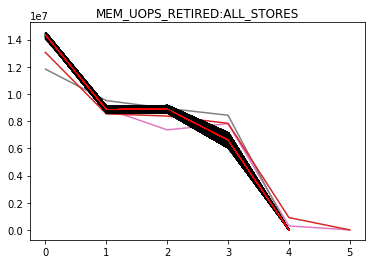

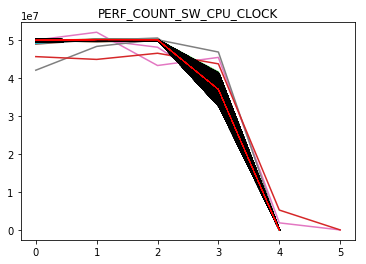

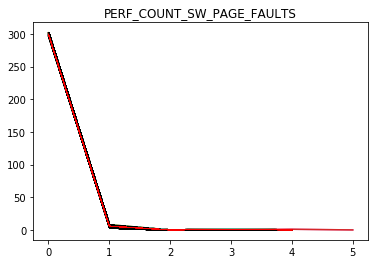

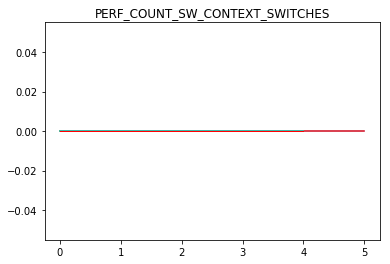

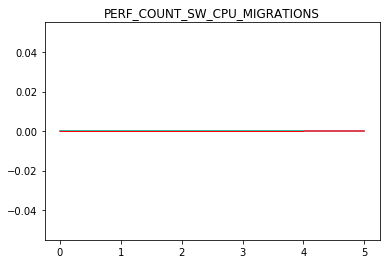

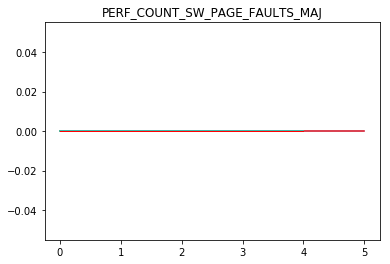

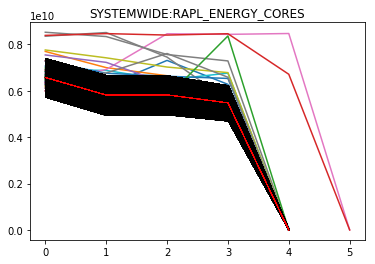

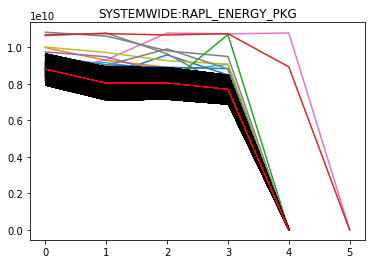

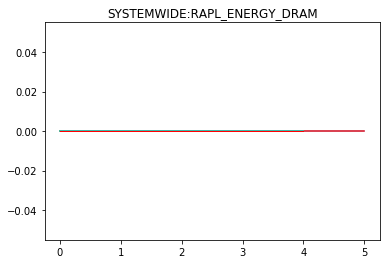

In [15]:
data= run_program(pargs=['polybench/covariance_MEDIUM_DATASET'],to_monitor=to_monitor,n=100,reset_on_sample=True,sample_period=0.05)
avg_df, std_df= smooth_df(data, flat_list(to_monitor))
for i, c in tqdm(enumerate(flat_list(to_monitor))):
    plt.figure()
    for r in data:
        aux= np.array(r)
        plt.plot(aux[:,i],zorder=0)
        
        aux= avg_df[c].values
        aux_std= std_df[c].values
        plt.fill_between(np.arange(aux.shape[0]), aux-3*aux_std, aux+3*aux_std,color='k',zorder=1)
        plt.plot(aux,c='r',linewidth=0.5)
    plt.title(c)

In [32]:
big_df=pd.DataFrame()
for i, df in enumerate(data):
    df= pd.DataFrame(df,columns=flat_list(to_monitor))
    df['run']= i
    big_df= pd.concat([big_df,df])
big_df.head(5)
#import seaborn as sns
#sns_plot= sns.pairplot(big_df,vars=['PERF_COUNT_HW_INSTRUCTIONS','MEM_UOPS_RETIRED:ALL_STORES','FP_COMP_OPS_EXE:X87',
                                   #'PERF_COUNT_HW_BRANCH_INSTRUCTIONS', 'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES'], hue="run",size=5)
#sns_plot.savefig("output.png")

,PERF_COUNT_HW_INSTRUCTIONS,PERF_COUNT_HW_BRANCH_INSTRUCTIONS,FP_COMP_OPS_EXE:X87,PERF_COUNT_HW_BRANCH_MISSES,PERF_COUNT_HW_CACHE_MISSES,MEM_UOPS_RETIRED:ALL_LOADS,MEM_UOPS_RETIRED:ALL_STORES,PERF_COUNT_SW_CPU_CLOCK,PERF_COUNT_SW_PAGE_FAULTS,PERF_COUNT_SW_CONTEXT_SWITCHES,PERF_COUNT_SW_CPU_MIGRATIONS,PERF_COUNT_SW_PAGE_FAULTS_MAJ,SYSTEMWIDE:RAPL_ENERGY_CORES,SYSTEMWIDE:RAPL_ENERGY_PKG,SYSTEMWIDE:RAPL_ENERGY_DRAM,run
0,269922,67485,0,3,62,555467,33749,39845977,1,0,0,0,7872905216,10175119360,0,0
1,561366,140347,0,6,80,1455882,70177,89210408,1,0,0,0,15740764160,20265435136,0,0
2,800014,200008,0,9,96,2337359,100002,135742418,1,0,0,0,23245619200,29946150912,0,0
3,800014,200008,0,9,96,2337359,100002,135742418,1,0,0,0,23245619200,29946150912,0,0
0,245698,61427,0,3,21,813966,30719,45653303,1,0,0,0,7330201600,9572319232,0,1
